# Face Parsing with UniFace

This notebook demonstrates face parsing (semantic segmentation) using the **UniFace** library.

Face parsing segments a face image into different facial components such as skin, eyes, nose, mouth, hair, etc.

## 1. Install UniFace

In [ ]:
%pip install -q uniface

# Clone repo for assets (Colab only)
import os
if 'COLAB_GPU' in os.environ or 'COLAB_RELEASE_TAG' in os.environ:
    if not os.path.exists('uniface'):
        !git clone --depth 1 https://github.com/yakhyo/uniface.git
    os.chdir('uniface/examples')

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import uniface
from uniface.parsing import BiSeNet
from uniface.constants import ParsingWeights
from uniface.visualization import vis_parsing_maps

print(f"UniFace version: {uniface.__version__}")

UniFace version: 2.0.0


## 3. Initialize BiSeNet Model

In [3]:
# Initialize face parser (uses ResNet18 by default)
parser = BiSeNet(model_name=ParsingWeights.RESNET34) # use resnet34 for better accuracy

✓ Model loaded (CoreML (Apple Silicon))


## 4. Face Parsing Classes

The BiSeNet model segments faces into **19 different classes**:

| Class ID | Component | Class ID | Component |
|----------|-----------|----------|----------|
| 0 | Background | 10 | Nose |
| 1 | Skin | 11 | Mouth |
| 2 | Left Eyebrow | 12 | Upper Lip |
| 3 | Right Eyebrow | 13 | Lower Lip |
| 4 | Left Eye | 14 | Neck |
| 5 | Right Eye | 15 | Neck Lace |
| 6 | Eye Glasses | 16 | Cloth |
| 7 | Left Ear | 17 | Hair |
| 8 | Right Ear | 18 | Hat |
| 9 | Ear Ring | | |

## 5. Process Test Images

The test images are already cropped face images, so we can directly parse them without face detection.

In [4]:
# Get all test images
test_images_dir = Path('../assets/test_images')
test_images = sorted(test_images_dir.glob('*.jpg'))

# Store original and processed images
original_images = []
parsed_images = []

for image_path in test_images:
    print(f"Processing: {image_path.name}")

    # Load image (already a face crop)
    image = cv2.imread(str(image_path))

    # Parse the face directly
    mask = parser.parse(image)
    unique_classes = len(set(mask.flatten()))
    print(f'  Parsed with {unique_classes} unique classes')

    # Visualize the parsing result
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    vis_result = vis_parsing_maps(image_rgb, mask, save_image=False)

    original_images.append(image_rgb)
    parsed_images.append(vis_result)

print(f"\nProcessed {len(test_images)} images")

Processing: image0.jpg
  Parsed with 13 unique classes
Processing: image1.jpg
  Parsed with 12 unique classes
Processing: image2.jpg
  Parsed with 11 unique classes
Processing: image3.jpg
  Parsed with 12 unique classes
Processing: image4.jpg
  Parsed with 10 unique classes

Processed 5 images


## 6. Visualize Results

Display original images in the first row and parsed images in the second row.

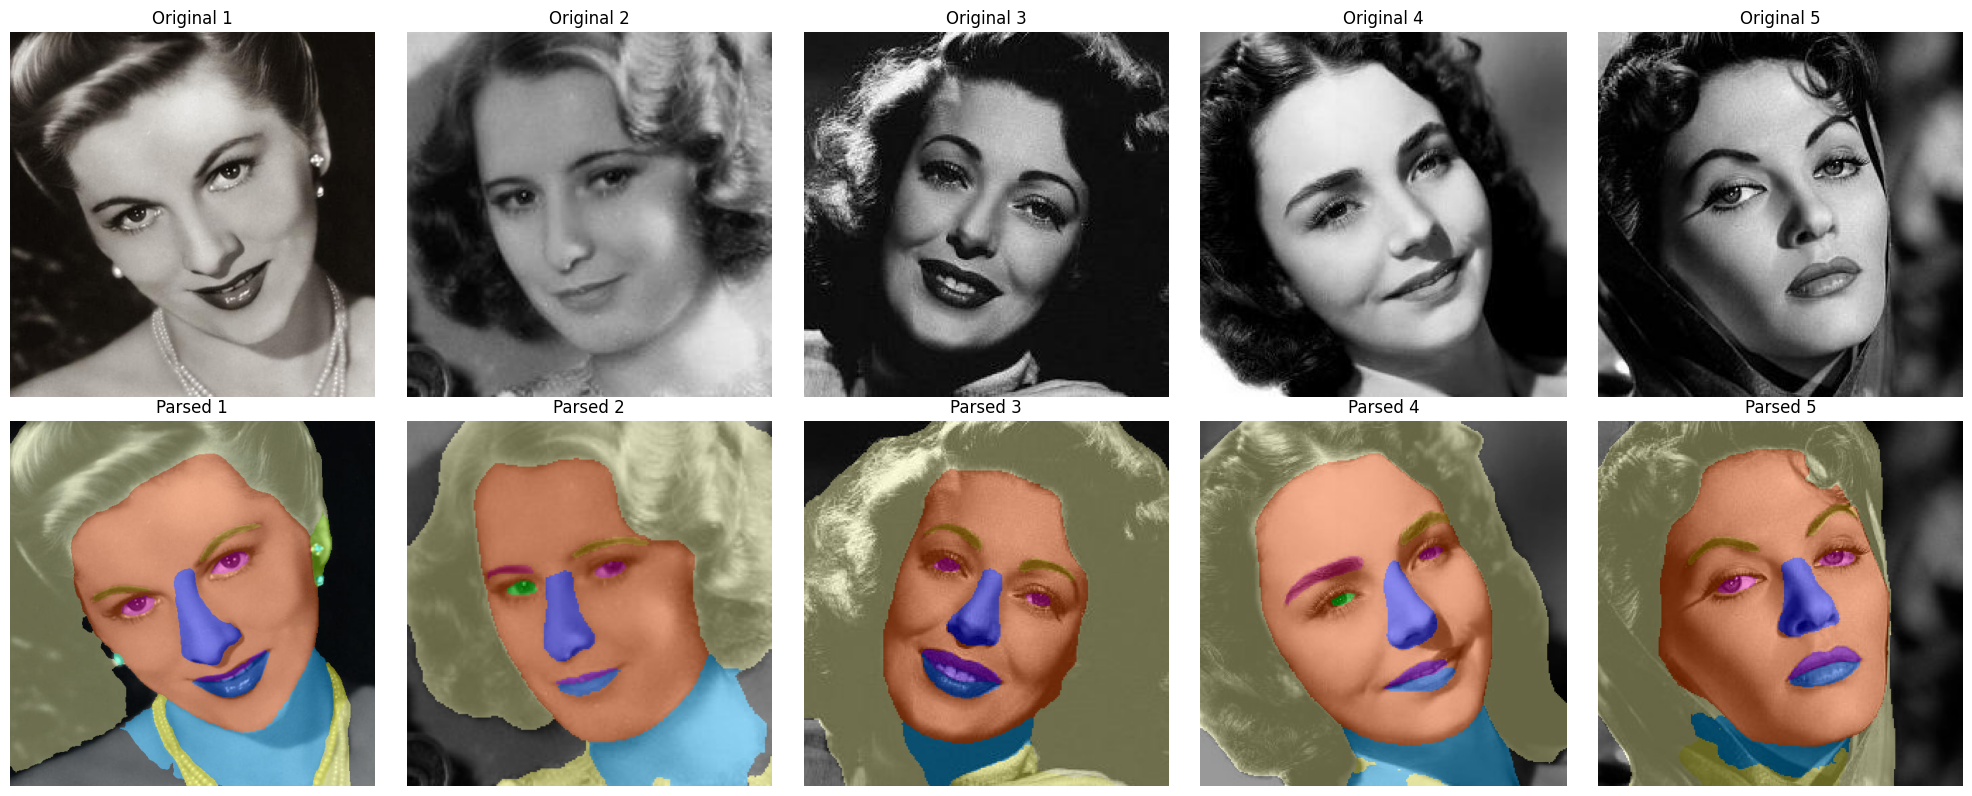

In [5]:
num_images = len(original_images)
fig, axes = plt.subplots(2, num_images, figsize=(4 * num_images, 8))

if num_images == 1:
    axes = axes.reshape(-1, 1)

for i in range(num_images):
    # Original image
    axes[0, i].imshow(original_images[i])
    axes[0, i].set_title(f'Original {i+1}', fontsize=12)
    axes[0, i].axis('off')

    # Parsed image
    axes[1, i].imshow(parsed_images[i])
    axes[1, i].set_title(f'Parsed {i+1}', fontsize=12)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 7. Parse a Single Face (Detailed)

Let's parse a single face and display the segmentation mask in detail.

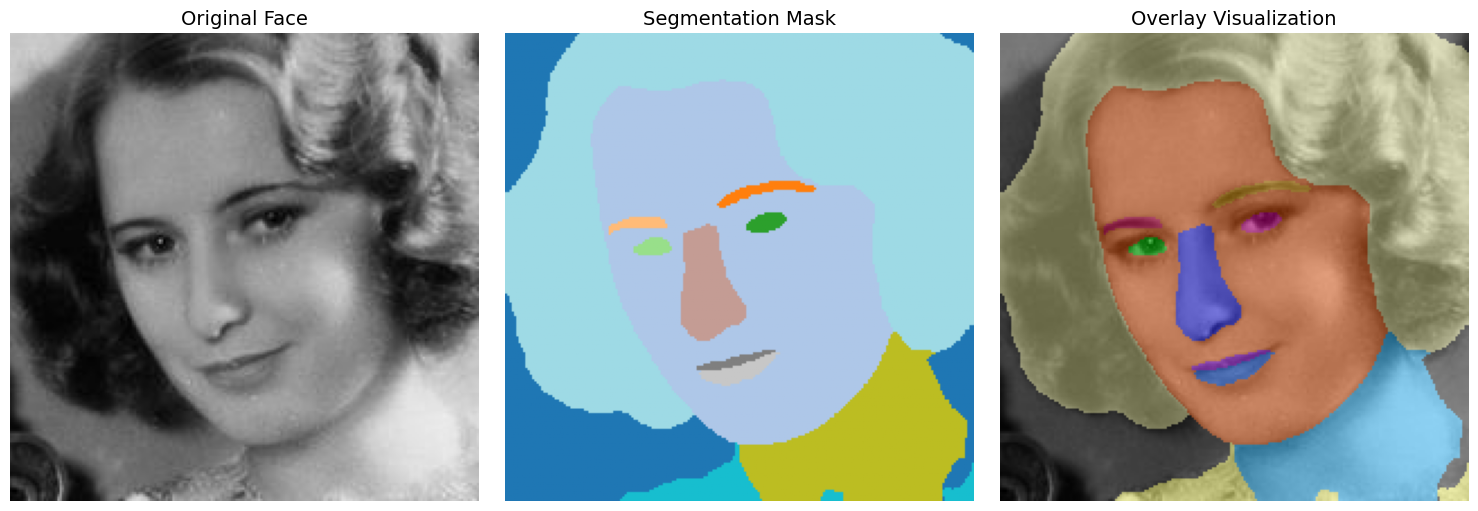

Mask shape: (208, 208)
Unique classes: [ 0  1  2  3  4  5 10 12 13 14 16 17]
Number of classes: 12


In [6]:
# Load a test image
image_path = '../assets/test_images/image1.jpg'
image = cv2.imread(image_path)

# Parse the face
mask = parser.parse(image)

# Visualize
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
vis_result = vis_parsing_maps(image_rgb, mask, save_image=False)

# Display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_rgb)
axes[0].set_title('Original Face', fontsize=14)
axes[0].axis('off')

axes[1].imshow(mask, cmap='tab20')
axes[1].set_title('Segmentation Mask', fontsize=14)
axes[1].axis('off')

axes[2].imshow(vis_result)
axes[2].set_title('Overlay Visualization', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Mask shape: {mask.shape}")
print(f"Unique classes: {np.unique(mask)}")
print(f"Number of classes: {len(np.unique(mask))}")

## 8. Extract Specific Facial Components

You can extract specific facial components using the mask.

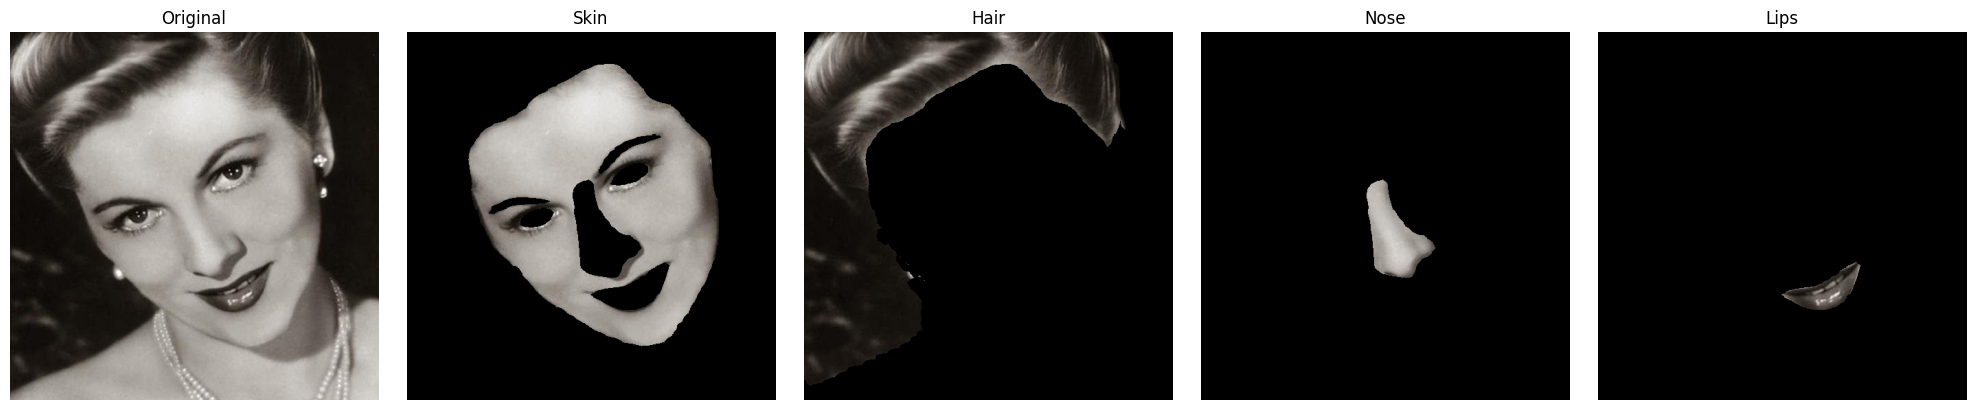

In [7]:
# Load image
image_path = '../assets/test_images/image0.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Parse the face
mask = parser.parse(image)

# Extract specific components
# 1 = skin, 17 = hair, 10 = nose, 12 = upper lip, 13 = lower lip
components_to_extract = {
    'Skin': 1,
    'Hair': 17,
    'Nose': 10,
    'Lips': [12, 13]  # Upper and lower lips combined
}

fig, axes = plt.subplots(1, len(components_to_extract) + 1, figsize=(20, 4))

# Show original
axes[0].imshow(image_rgb)
axes[0].set_title('Original', fontsize=12)
axes[0].axis('off')

# Extract and show each component
for idx, (name, class_ids) in enumerate(components_to_extract.items(), 1):
    # Handle both single class and multiple classes
    if isinstance(class_ids, list):
        component_mask = np.zeros_like(mask, dtype=np.uint8)
        for class_id in class_ids:
            component_mask |= (mask == class_id).astype(np.uint8)
    else:
        component_mask = (mask == class_ids).astype(np.uint8)

    # Apply mask to image
    extracted = image_rgb.copy()
    extracted[component_mask == 0] = 0

    axes[idx].imshow(extracted)
    axes[idx].set_title(name, fontsize=12)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()